# Credit Risk Modeling: Preprocessing 

In [1394]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [1396]:
df = pd.read_csv('loans_full_schema.csv')

In [1398]:
df.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


## 2.1 Data Cleaning

In [1401]:
clean_df = df.copy()

In [1405]:
X = clean_df.drop(columns=['loan_status'])
y = clean_df['loan_status']

### 2.2 Duplicate Values
No preprocessing of duplicate values is required. 

In [1408]:
X.duplicated().sum()

0

### 2.3 Missing Values

My strategy for handling the missing data is informed by the follow:
1. Percentage of Missing Data: A higher percentage might lean towards dropping the column or more sophisticated imputation.

2. Nature of the Column: Is it numerical or categorical? What does "missing" actually mean in the context of that specific variable?

3. Importance to the Model: Is this column likely to be a strong predictor for your target variable (loan_status)?

4. Assumptions about Missingness: Is the data Missing Completely At Random (MCAR), Missing At Random (MAR), or Missing Not At Random (MNAR)

In [1410]:
df_missing = X.isna().sum().to_frame().rename(columns={0: 'count'}).sort_values(by=['count'], ascending=False)
df_missing['pct'] = round(df_missing['count'] / len(X) * 100, 3)
missing_df = df_missing[df_missing['count'] > 0]
missing_df

,count,pct
verification_income_joint,8545,85.45
debt_to_income_joint,8505,85.05
annual_income_joint,8505,85.05
months_since_90d_late,7715,77.15
months_since_last_delinq,5658,56.58
months_since_last_credit_inquiry,1271,12.71
emp_title,833,8.33
emp_length,817,8.17
num_accounts_120d_past_due,318,3.18
debt_to_income,24,0.24


#### 2.3.1 Creating new column df[__is_joint_applicant__]

The "joint" columns [[`verification_income_joint`,`debt_to_income_joint`,`annual_income_joint`]] had a very high percentage of missing values. By creating is_joint_applicant, I've effectively transformed these missing values into meaningful information: if all three joint columns are missing, it strongly indicates an individual application, which is now explicitly represented by False (or 0). This avoids the need for complex imputation strategies for those specific columns if their primary purpose is just to flag joint applications.

In [1414]:
X['is_joint_applicant'] = X[['annual_income_joint', 'verification_income_joint', 'debt_to_income_joint']].notna().any(axis=1)
X['is_joint_applicant'] = X['is_joint_applicant'].astype(int)
X['is_joint_applicant'].value_counts(normalize=True)

is_joint_applicant
0    0.8505
1    0.1495
Name: proportion, dtype: float64

In [1334]:
X = X.drop(['verification_income_joint', 'debt_to_income_joint', 'annual_income_joint'], axis=1)

In [1335]:
X.shape

(10000, 53)

The `is_joint_applicant` column now effectively captures the core information needed from the "joint" columns: whether or not an applicant is joint. Given that fewer features mean a simpler model, faster training times, and fewer issues with multicollinearity I will now drop the original "joint" columns from the dataset.

#### 2.3.2 emp_length

In [1338]:
clean_df['emp_length'].describe()

count    9183.000000
mean        5.930306
std         3.703734
min         0.000000
25%         2.000000
50%         6.000000
75%        10.000000
max        10.000000
Name: emp_length, dtype: float64

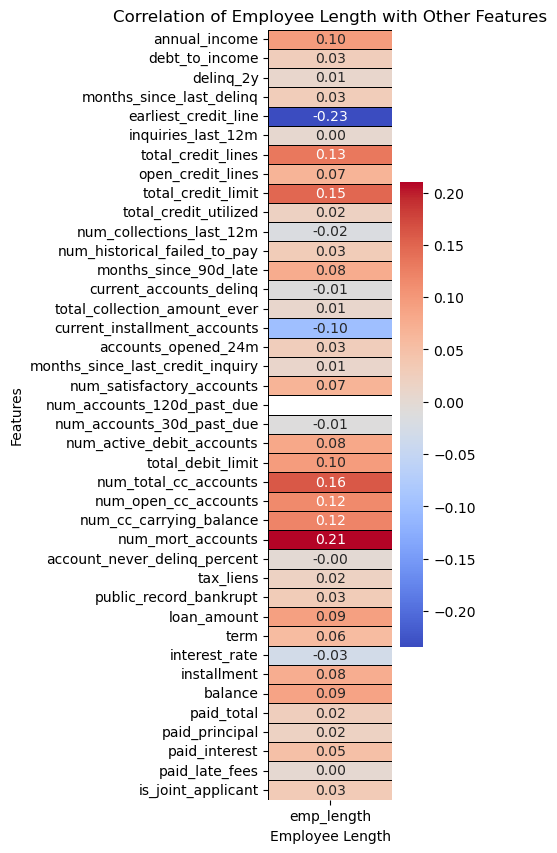


Correlation of 'emp_length' with other features:
                                  emp_length
annual_income                       0.096469
debt_to_income                      0.026157
delinq_2y                           0.008242
months_since_last_delinq            0.028790
earliest_credit_line               -0.234408
inquiries_last_12m                  0.003753
total_credit_lines                  0.133472
open_credit_lines                   0.067415
total_credit_limit                  0.147594
total_credit_utilized               0.019694
num_collections_last_12m           -0.015729
num_historical_failed_to_pay        0.029997
months_since_90d_late               0.077553
current_accounts_delinq            -0.011075
total_collection_amount_ever        0.007772
current_installment_accounts       -0.099357
accounts_opened_24m                 0.027457
months_since_last_credit_inquiry    0.008758
num_satisfactory_accounts           0.067049
num_accounts_120d_past_due               NaN
num_a

In [1339]:
numerical_df = clean_df.select_dtypes(include=[np.number])

correlation_matrix = numerical_df.corr()
emp_length_correlations = correlation_matrix[['emp_length']].drop('emp_length') 

plt.figure(figsize=(2, 10)) 
sns.heatmap(
    emp_length_correlations,
    annot=True,       # Show the correlation values on the heatmap
    cmap='coolwarm',  # Color map (coolwarm is good for showing positive/negative correlations)
    fmt=".2f",        # Format annotations to two decimal places
    cbar=True,        # Show color bar
    linewidths=0.5,   # Add lines between cells
    linecolor='black' # Color of the lines
)
plt.title('Correlation of Employee Length with Other Features')
plt.ylabel('Features')
plt.xlabel('Employee Length')
plt.yticks(rotation=0) # Keep y-axis labels horizontal for readability
plt.show()

# --- Optional: Print the correlation values directly ---
print("\nCorrelation of 'emp_length' with other features:")
print(emp_length_correlations)

In [1340]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler

print("\nNaNs in emp_length before imputation:", clean_df['emp_length'].isnull().sum())

# --- 2. Identify Top 3 Correlated Features with 'emp_length' ---
numerical_df = clean_df.select_dtypes(include=[np.number])
correlation_matrix = numerical_df.corr()

emp_length_correlations = correlation_matrix['emp_length'].drop('emp_length')
top_3_correlated_features = emp_length_correlations.abs().nlargest(3).index.tolist()

print(f"\nTop 3 features most correlated with 'emp_length': {top_3_correlated_features}")


NaNs in emp_length before imputation: 817

Top 3 features most correlated with 'emp_length': ['earliest_credit_line', 'num_mort_accounts', 'num_total_cc_accounts']


In [1341]:
# --- 3. Prepare Data for Imputation ---
# Select 'emp_length' and the top 3 correlated features
features_for_imputation = top_3_correlated_features + ['emp_length']
data_for_imputation = clean_df[features_for_imputation].copy()

In [1342]:
# --- 4. Scale the Data ---
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_imputation)
scaled_df = pd.DataFrame(scaled_data, columns=features_for_imputation, index=data_for_imputation.index)

# --- 5. Apply KNN Imputation ---
imputer = KNNImputer(n_neighbors=5, weights='uniform')
imputed_scaled_data = imputer.fit_transform(scaled_df)
imputed_scaled_df = pd.DataFrame(imputed_scaled_data, columns=features_for_imputation, index=data_for_imputation.index)

# Inverse transform the imputed data to get original scale values
imputed_original_scale_data = scaler.inverse_transform(imputed_scaled_df)

# Convert back to DataFrame
imputed_clean_df_part = pd.DataFrame(imputed_original_scale_data, columns=features_for_imputation, index=data_for_imputation.index)
clean_df['emp_length'] = imputed_clean_df_part['emp_length']

print("\nNaNs in emp_length after imputation:", clean_df['emp_length'].isnull().sum())


NaNs in emp_length after imputation: 0


#### 2.3.3 num_accounts_120d_past_due

In [1344]:
clean_df['num_accounts_120d_past_due'].describe()

count    9682.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: num_accounts_120d_past_due, dtype: float64

In [1345]:
clean_df = clean_df.drop('num_accounts_120d_past_due', axis=1)

#### 2.3.4 debt_to_income

In [1347]:
df['debt_to_income'].describe()

count    9976.000000
mean       19.308192
std        15.004851
min         0.000000
25%        11.057500
50%        17.570000
75%        25.002500
max       469.090000
Name: debt_to_income, dtype: float64

In [1348]:
clean_df['debt_to_income'] = clean_df['debt_to_income'].fillna(clean_df['debt_to_income'].median())

#### 2.3.5 months_since_90d_late column

#### Sentinel Values
The column `months_since_90d_late` and `months_since_last_delinq` columns are missing 77.15% and 56.58% of their values respectively. It's highly probable that a missing value here means the individual has never been 90 days late or has never had a delinquency. I will impute with a value larger than the maximum observed value in the non-missing data allowing the model to distinguish between "actual delinquency x months ago" and "never delinq."

In [1351]:
clean_df['months_since_90d_late'].unique()

array([ 38.,  nan,  28.,  60.,  71.,  18.,  37.,   6.,  22.,  67.,  44.,
        70.,  68., 102.,  80.,  42.,  49.,  43.,  15.,  34.,  36.,  58.,
        19.,  59.,   5.,  62.,  47.,  23.,  53.,  24.,  39.,  26.,  45.,
        66.,  51.,  32.,  55.,  73.,  64.,  21.,  76.,  79.,  63.,  82.,
        27.,  69.,  50.,  72.,  41.,  54.,  74.,  75.,  30.,  57.,  16.,
        46.,  31.,   8.,  17.,  35.,  33.,  65.,  78.,  12.,  52.,  48.,
         7.,  13.,  40.,  81.,   9.,  61., 106.,  29.,  20.,  99., 113.,
        25., 128.,   4.,  77.,  56.,  10.,  11.,  84.,  97.,   3.,  14.,
        92., 112.,  88.,  91., 101., 115.,  89.,   2., 118., 109.,  87.,
       100.,  96.,  85., 120., 107.,  90.,  83.,  98.])

In [1352]:
clean_df['months_since_90d_late'].max()

128.0

In [1353]:
clean_df['months_since_90d_late'] = clean_df['months_since_90d_late'].fillna(999)
clean_df['months_since_90d_late'].max()

999.0

#### 2.3.6 months_since_last_delinq column

In [1355]:
clean_df['months_since_last_delinq'].unique()

array([ 38.,  nan,  28.,   3.,  19.,  18.,  50.,  37.,  44.,   6.,  77.,
        14.,  67.,  70.,  68.,  35.,  31., 102.,  80.,  61.,  26.,   7.,
        49.,  43.,  15.,  75.,  27.,  34.,  56.,  36.,  48.,  58.,  59.,
         5.,  62.,  22.,  47.,  78.,  10.,  53.,  24.,  39.,  45.,  12.,
        32.,  25.,  29.,  55.,  63.,  81.,  16.,  21.,  33.,  79.,  60.,
        82.,  69.,   4.,  66.,  52.,  20.,  30.,  41.,  57.,  64.,  11.,
         1.,  71.,  23.,  13.,   8.,  72.,  17.,  51.,  74.,   9.,  46.,
        54.,  65.,  42.,  83.,  76.,  73.,  99.,  40.,  84.,   2.,  91.,
       101.,  89.,  87., 100.,  96., 109.,  88., 118., 106.,  98.])

In [1356]:
clean_df['months_since_last_delinq'].max()

118.0

In [1357]:
clean_df['months_since_last_delinq'] = clean_df['months_since_last_delinq'].fillna(999)
clean_df['months_since_last_delinq'].max()

999.0

#### 2.3.7 months_since_last_credit_inquiry

__Current__ and __Fully Paid__ have higher mean months_since_last_credit_inquiry values. This suggests that for loans that are actively being paid or have been fully paid off, the average time since their last credit inquiry is longer. This intuitively makes sense as stable borrowers might not need frequent new credit inquiries. __Charged Off__ , __Late (16-30 days)__,  __Late (31-120 days)__, and __In Grace Period__  generally show lower mean months_since_last_credit_inquiry values. This could indicate that borrowers who are struggling (late, in grace, or charged off) might have had more recent credit inquiries. This also makes sense as they might be seeking new credit or consolidating debt leading to more recent inquiries.
* It is important to note that there is a class imbalance in the target variable `loan_status`. Because __Current__ has the largest number of samples, its mean (7.41) is statistically more robust and representative of that group. The means for the minority classes (like 'Charged Off', 'In Grace Period', 'Late') are derived from much smaller sample sizes.

In [1360]:
mean_inquiry_by_status = clean_df.groupby('loan_status')['months_since_last_credit_inquiry'].mean().sort_values(ascending=False)
print("\nMean months_since_last_credit_inquiry by loan_status:")
mean_inquiry_by_status


Mean months_since_last_credit_inquiry by loan_status:


loan_status
Current               7.414287
Fully Paid            6.564356
Late (16-30 days)     6.205882
In Grace Period       5.887097
Late (31-120 days)    5.295082
Charged Off           2.571429
Name: months_since_last_credit_inquiry, dtype: float64

In [1361]:
print("\nFrequency of each value:")
all_status_counts = clean_df['loan_status'].value_counts()
all_status_counts


Frequency of each value:


loan_status
Current               9375
Fully Paid             447
In Grace Period         67
Late (31-120 days)      66
Late (16-30 days)       38
Charged Off              7
Name: count, dtype: int64

In [1362]:
clean_df['months_since_last_credit_inquiry'] = clean_df['months_since_last_credit_inquiry'].fillna(999)
clean_df['months_since_last_credit_inquiry'].max()

999.0

#### 2.3.8 emp_title

__Strategy 1: Word2Vec__

In [1364]:
import re
from gensim.models import Word2Vec

In [1365]:
# --- Step 1: Preprocessing and Tokenization ---
clean_df['emp_title_processed'] = clean_df['emp_title'].fillna('Unknown')

# IMPORTANT: Apply the more robust tokenization function from previous examples
def tokenize_job_title(title):
    if pd.isna(title):
        return [] # Return empty list for NaN/None titles
    title = str(title).lower()
    title = re.sub(r'[^a-z\s]', '', title) # Remove special characters and numbers
    words = [word for word in title.split() if word]
    return words

# Assign the tokenized lists to a new column in clean_df
clean_df['tokenized_job_title'] = clean_df['emp_title_processed'].apply(tokenize_job_title)

# The 'sentences' for Word2Vec are now directly from this new column
sentences = clean_df['tokenized_job_title'].tolist()

In [1366]:
# --- Step 2: Train the Word2Vec Model ---
model = Word2Vec(
    sentences=sentences,
    vector_size=100,      # Dimensionality of the embedding vectors (e.g., 50, 100, 200)
    window=4,             # Context window size (how many words around the target word to consider)
    min_count=1,          # Minimum frequency for a word to be included in the vocabulary
    sg=0,                 # 1 for Skip-gram (better for infrequent words), 0 for CBOW
    epochs=100,           # Number of training iterations
    workers=4             # Number of CPU cores to use
)

print(f"\nVocabulary size: {len(model.wv.index_to_key)} unique words")


Vocabulary size: 2345 unique words


In [1367]:
# --- Step 3: Create Mapping and Helper Functions ---
# Create a mapping from word to its embedding vector
word_to_embedding = {word: model.wv[word] for word in model.wv.index_to_key}
vector_dim = model.wv.vector_size

# Function to get embedding for a single word, handling OOV
def get_word_embedding(word, embedding_map, vector_size):
    if word in embedding_map:
        return embedding_map[word]
    else:
        # Handle out-of-vocabulary (OOV) words:
        # Return a zero vector, or an average of all embeddings, or a dedicated <UNK> token embedding.
        return [0.0] * vector_size

# Function to get an aggregated embedding for an entire job title
def get_job_title_embedding(tokenized_title_words, embedding_map, vector_size):
    word_embeddings_list = []
    for word in tokenized_title_words:
        embedding = get_word_embedding(word, embedding_map, vector_size)
        if any(x != 0.0 for x in embedding): # Only add if not an OOV zero vector
            word_embeddings_list.append(embedding)

    if not word_embeddings_list: # If the title was empty or all words were OOV
        return [0.0] * vector_size
    else:
        # Aggregation Strategy: Mean Pooling (most common)
        return list(np.mean(word_embeddings_list, axis=0))


In [1368]:
# --- Step 4: Apply Embeddings to DataFrame ---
# Apply the aggregation function to your tokenized job titles column
# Use clean_df consistently
clean_df['job_title_embedding'] = clean_df['tokenized_job_title'].apply(
    lambda x: get_job_title_embedding(x, word_to_embedding, vector_dim)
)

# Expand the list of embeddings into separate columns
job_title_embedding_df = pd.DataFrame(
    clean_df['job_title_embedding'].tolist(),
    index=clean_df.index,
    columns=[f'job_embed_{i}' for i in range(vector_dim)]
)

# Concatenate with your original DataFrame (clean_df),
# dropping the original 'emp_title', 'emp_title_processed', 'tokenized_job_title', and 'job_title_embedding'
# Keep 'employee_id' and 'some_other_feature'
clean_df = pd.concat([
    clean_df.drop(columns=['emp_title', 'emp_title_processed', 'tokenized_job_title', 'job_title_embedding']),
    job_title_embedding_df
], axis=1)

print("\nDataFrame with Job Title Embeddings:")
print(clean_df.head())
print(f"Shape of encoded DataFrame: {clean_df.shape}")


DataFrame with Job Title Embeddings:
   emp_length state homeownership  annual_income  verified_income  \
0         3.0    NJ      MORTGAGE        90000.0         Verified   
1        10.0    HI          RENT        40000.0     Not Verified   
2         3.0    WI          RENT        40000.0  Source Verified   
3         1.0    PA          RENT        30000.0     Not Verified   
4        10.0    CA          RENT        35000.0         Verified   

   debt_to_income  delinq_2y  months_since_last_delinq  earliest_credit_line  \
0           18.01          0                      38.0                  2001   
1            5.04          0                     999.0                  1996   
2           21.15          0                      28.0                  2006   
3           10.16          0                     999.0                  2007   
4           57.96          0                     999.0                  2008   

   inquiries_last_12m  ...  job_embed_90  job_embed_91  job_embed_

__Strategy 2: BERT__

In [1370]:
'''
import re
import torch
from transformers import AutoTokenizer, AutoModel


# Basic cleaning (optional but good practice to remove unnecessary noise)
def clean_job_title(title):
    if pd.isna(title):
        return ""
    title = str(title).lower()
    # Remove excessive whitespace, special characters might be kept or removed based on needs
    title = re.sub(r'\s+', ' ', title).strip()
    return title

clean_df['cleaned_job_title'] = clean_df['emp_title'].apply(clean_job_title)

# The list of job titles to process
job_titles = clean_df['cleaned_job_title'].tolist()
print("Cleaned Job Titles for BERT:")
for i, title in enumerate(job_titles[:5]):
    print(f"Row {i+1}: '{title}'")
'''

'\nimport re\nimport torch\nfrom transformers import AutoTokenizer, AutoModel\n\n\n# Basic cleaning (optional but good practice to remove unnecessary noise)\ndef clean_job_title(title):\n    if pd.isna(title):\n        return ""\n    title = str(title).lower()\n    # Remove excessive whitespace, special characters might be kept or removed based on needs\n    title = re.sub(r\'\\s+\', \' \', title).strip()\n    return title\n\nclean_df[\'cleaned_job_title\'] = clean_df[\'emp_title\'].apply(clean_job_title)\n\n# The list of job titles to process\njob_titles = clean_df[\'cleaned_job_title\'].tolist()\nprint("Cleaned Job Titles for BERT:")\nfor i, title in enumerate(job_titles[:5]):\n    print(f"Row {i+1}: \'{title}\'")\n'

In [1371]:
'''
# Choose a pre-trained BERT model
bert = 'bert-base-uncased' # Or 'bert-base-cased', 'roberta-base', etc.

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(bert)
model = AutoModel.from_pretrained(bert)

# Set the model to evaluation mode (important for inference)
model.eval()

# Check if CUDA (GPU) is available and move model to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"\nUsing device: {device}")
'''

'\n# Choose a pre-trained BERT model\nbert = \'bert-base-uncased\' # Or \'bert-base-cased\', \'roberta-base\', etc.\n\n# Load tokenizer and model\ntokenizer = AutoTokenizer.from_pretrained(bert)\nmodel = AutoModel.from_pretrained(bert)\n\n# Set the model to evaluation mode (important for inference)\nmodel.eval()\n\n# Check if CUDA (GPU) is available and move model to GPU\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nmodel.to(device)\nprint(f"\nUsing device: {device}")\n'

In [1372]:
'''
def get_bert_embeddings(texts, tokenizer, model, device, max_length=128, batch_size=32):
    all_embeddings = []
    
    # Process in batches to manage memory and speed up
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        
        # Tokenize the batch
        encoded_input = tokenizer(
            batch_texts,
            padding=True,          # Pad sequences to the longest sequence in the batch
            truncation=True,       # Truncate sequences longer than max_length
            max_length=max_length, # Max sequence length
            return_tensors='pt'    # Return PyTorch tensors
        )
        
        # Move inputs to the same device as the model
        input_ids = encoded_input['input_ids'].to(device)
        attention_mask = encoded_input['attention_mask'].to(device)
        
        with torch.no_grad(): # Disable gradient calculation for inference
            # Get model outputs (hidden states)
            # `last_hidden_state` is a tensor of shape (batch_size, sequence_length, hidden_size)
            # `pooler_output` is a tensor of shape (batch_size, hidden_size) and is the
            # representation of the [CLS] token, often used for sequence-level tasks.
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            # --- Aggregation Strategy ---
            # Option 1: Use the [CLS] token's embedding (pooler_output)
            # This is a common choice for getting a single sentence embedding
            batch_embeddings = outputs.pooler_output.cpu().numpy()
            
            # Option 2: Mean pooling of all token embeddings
            # This can sometimes be more robust than just the [CLS] token
            # token_embeddings = outputs.last_hidden_state # (batch_size, sequence_length, hidden_size)
            # input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
            # sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
            # sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
            # batch_embeddings = (sum_embeddings / sum_mask).cpu().numpy()
            
            all_embeddings.extend(batch_embeddings)
            
    return all_embeddings

# Generate embeddings for all job titles
bert_embeddings = get_bert_embeddings(
    job_titles,
    tokenizer,
    model,
    device,
    max_length=64, # Job titles are usually short, so a smaller max_length is fine
    batch_size=16  # Adjust based on your GPU memory and dataset size
)

print(f"\nGenerated {len(bert_embeddings)} embeddings, each with dimension: {len(bert_embeddings[0])}")
print("First embedding (first 5 values):", bert_embeddings[0][:5])
'''

'\ndef get_bert_embeddings(texts, tokenizer, model, device, max_length=128, batch_size=32):\n    all_embeddings = []\n    \n    # Process in batches to manage memory and speed up\n    for i in range(0, len(texts), batch_size):\n        batch_texts = texts[i:i + batch_size]\n        \n        # Tokenize the batch\n        encoded_input = tokenizer(\n            batch_texts,\n            padding=True,          # Pad sequences to the longest sequence in the batch\n            truncation=True,       # Truncate sequences longer than max_length\n            max_length=max_length, # Max sequence length\n            return_tensors=\'pt\'    # Return PyTorch tensors\n        )\n        \n        # Move inputs to the same device as the model\n        input_ids = encoded_input[\'input_ids\'].to(device)\n        attention_mask = encoded_input[\'attention_mask\'].to(device)\n        \n        with torch.no_grad(): # Disable gradient calculation for inference\n            # Get model outputs (hidden

In [1373]:
'''
# Convert list of embeddings to a DataFrame
embedding_df = pd.DataFrame(bert_embeddings, index=df.index,
                            columns=[f'bert_embed_{i}' for i in range(len(bert_embeddings[0]))])

# Concatenate with your original DataFrame, dropping the original text columns
clean_df_final = pd.concat([clean_df.drop(columns=['emp_title', 'cleaned_job_title']), embedding_df], axis=1)

print("\nFinal DataFrame with BERT Embeddings:")
print(clean_df_final.head())
print(f"Shape of final DataFrame: {clean_df_final.shape}")
'''

'\n# Convert list of embeddings to a DataFrame\nembedding_df = pd.DataFrame(bert_embeddings, index=df.index,\n                            columns=[f\'bert_embed_{i}\' for i in range(len(bert_embeddings[0]))])\n\n# Concatenate with your original DataFrame, dropping the original text columns\nclean_df_final = pd.concat([clean_df.drop(columns=[\'emp_title\', \'cleaned_job_title\']), embedding_df], axis=1)\n\nprint("\nFinal DataFrame with BERT Embeddings:")\nprint(clean_df_final.head())\nprint(f"Shape of final DataFrame: {clean_df_final.shape}")\n'

In [1374]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 151 entries, emp_length to job_embed_99
dtypes: float32(100), float64(14), int64(26), object(11)
memory usage: 7.7+ MB


In [1390]:
ordinal_categories = [
    # For 'grade'
    ['A', 'B', 'C', 'D', 'E', 'F', 'G'],

        'A1', 'A2', 'A3', 'A4', 'A5',
        'B1', 'B2', 'B3', 'B4', 'B5',
        'C1', 'C2', 'C3', 'C4', 'C5',
        'D1', 'D2', 'D3', 'D4', 'D5',
        'E1', 'E2', 'E3', 'E4', 'E5',
        'F1', 'F2', 'F3', 'F4', 'F5',
        'G1', 'G2', 'G3', 'G4', 'G5'
    ]
]


# Instantiate the encoder
ordinal_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='error', # Important: Handles any unexpected categories by assigning NaN

)

nominal_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)


# Example usage (assuming 'grade' and 'sub_grade' are columns in your DataFrame X)
X_train_ordinal_encoded = ordinal_transformer.fit_transform(clean_df[['grade', 'sub_grade']])


In [1392]:
X_train_nominal_encoded = nominal_transformer.fit_transform(clean_df[['state', 'verified_income', 'loan_purpose', 'application_type', 'issue_month','loan_status',
                'initial_listing_status', 'disbursement_method','homeownership']])

## 3.0  Data Transformation

In [1382]:
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, RobustScaler,
    OrdinalEncoder, OneHotEncoder, LabelEncoder
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')


# Define column types
features_df = clean_df.drop(columns=['loan_status'])
numerical = features_df.select_dtypes(include=np.number).columns.tolist()

nominal = ['state', 'verified_income', 'loan_purpose', 'application_type', 'issue_month','loan_status',
                'initial_listing_status', 'disbursement_method','homeownership']
ordinal = ['grade','sub_grade']
passthrough = ['emp_title']


# Define ordinal mappings (category order matters)
ordinal_categories = [
    ['A','B','C','D','E','F','G'], 
    ['A1','A2','A3','A4','A5',
     'B1','B2','B3','B4','B5',
     'C1','C2','C3','C4','C5',
     'D1','D2','D3','D4','D5',
     'E1','E2','E3','E4','E5',
     'F1','F2','F3','F4','F5',
     'G1','G2','G3','G4','G5'
    ]
]


numerical_transformer = StandardScaler()

ordinal_transformer = OrdinalEncoder(
    categories=ordinal_categories,
    handle_unknown='ignore'
)

nominal_transformer = OneHotEncoder(
    handle_unknown='ignore',
    sparse_output=False
)


preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical),
        ('ord', ordinal_transformer, ordinal),
        ('nom', nominal_transformer, nominal),
        ('pass', 'passthrough', passthrough)
    ],
    remainder= 'passthrough'  # drop any remaining columns
)


pipeline = Pipeline(
    steps = [
        ('preprocessor',preprocessor)
    ]
)


In [1384]:
# Fit the preprocessor
preprocessor.fit(clean_df)
print("Preprocessor fitted successfully!")

# Transform the data
df_transformed = preprocessor.transform(df)
print(f"Data transformed! New shape: {df_transformed.shape}")

# Generate feature names for the transformed data
feature_names = []

# Add numerical feature names
feature_names.extend(numerical_cols)

# Add ordinal feature names
feature_names.extend(ordinal_cols)

# Add nominal feature names (one-hot encoded)
nom_feature_names = preprocessor.named_transformers_['nom'].get_feature_names_out(nominal_cols)
feature_names.extend(nom_feature_names)

# Convert to DataFrame with proper column names
df_final = pd.DataFrame(df_transformed, columns=feature_names, index=df.index)

print(f"\nFinal feature names ({len(feature_names)} total):")
for i, name in enumerate(feature_names, 1):
    print(f"  {i:2d}. {name}")

print(f"\nTransformed data preview:")
print(df_final.head())

print(f"\nTransformed data statistics:")
print(df_final.describe())

'''
# Verify transformations
print("\n" + "="*60)
print("TRANSFORMATION VERIFICATION")
print("="*60)

# Check numerical features (should be standardized - mean~0, std~1)
print("Numerical features after standardization:")
for col in numerical_cols:
    mean_val = df_final[col].mean()
    std_val = df_final[col].std()
    print(f"  {col}: mean={mean_val:.6f}, std={std_val:.6f}")

# Check ordinal features (should be integers representing order)
print(f"\nOrdinal features after encoding:")
for col in ordinal_cols:
    unique_vals = sorted(df_final[col].unique())
    print(f"  {col}: encoded values = {unique_vals}")

# Check nominal features (should be binary 0/1 for one-hot)
print(f"\nNominal features after one-hot encoding:")
nom_columns = [col for col in df_final.columns if any(nom_col in col for nom_col in nominal_cols)]
print(f"  Created {len(nom_columns)} binary columns from {len(nominal_cols)} nominal features")


'''
'''
# Create alternative pipeline configurations
print("\n" + "="*60)
print("ALTERNATIVE CONFIGURATIONS")
print("="*60)

# Configuration 2: MinMax scaling + Label encoding for nominals
print("Configuration 2: MinMax + Label Encoding")
preprocessor2 = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', LabelEncoder(), nominal_cols[0])  # LabelEncoder works on single column
    ],
    remainder='drop'
)

# For multiple nominal columns with LabelEncoder, we need separate transformers
label_transformers = []
for i, col in enumerate(nominal_cols):
    label_transformers.append((f'nom_{i}', LabelEncoder(), [col]))

preprocessor2_full = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols)
    ] + label_transformers,
    remainder='drop'
)

df_transformed2 = preprocessor2_full.fit_transform(df)
print(f"  Shape with MinMax + Label: {df_transformed2.shape}")

# Configuration 3: Robust scaling
print("Configuration 3: Robust Scaling + OneHot")
preprocessor3 = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numerical_cols),
        ('ord', ordinal_transformer, ordinal_cols),
        ('nom', OneHotEncoder(handle_unknown='ignore', sparse_output=False), nominal_cols)
    ],
    remainder='drop'
)

df_transformed3 = preprocessor3.fit_transform(df)
print(f"  Shape with Robust + OneHot: {df_transformed3.shape}")

print("\n" + "="*60)
print("PIPELINE COMPLETE")
print("="*60)
print(f"Original data: {df.shape}")
print(f"Final transformed data: {df_final.shape}")
print("✓ Numerical features: normalized/scaled")
print("✓ Ordinal features: properly encoded with order preserved")
print("✓ Nominal features: one-hot encoded")
print("✓ Ready for machine learning!")

# Save the results (optional)
# df_final.to_csv('preprocessed_data.csv', index=False)
# print("Preprocessed data saved to 'preprocessed_data.csv'")
'''

ValueError: No valid specification of the columns. Only a scalar, list or slice of all integers or all strings, or boolean mask is allowed